# Object detection: Bounding box regression 

What is bounding box regression?

We are all likely familiar with the concept of image classification via deep neural networks. When performing image classification, we:

- Present an input image to the CNN
- Perform a forward pass through the CNN
- Output a vector with N elements, where N is the total number of class labels
- Select the class label with the largest probability as our final predicted class label

But unfortunately, that type of model doesn’t translate to object detection. **It would be impossible for us to construct a class label for every possible combination of (x, y)-coordinate bounding boxes in an input image.**

Instead, we need to rely on a different type of machine learning model called **regression**. Unlike classification, which produces a label, **regression enables us to predict continuous values.**

The point here is that a regression model’s output isn’t limited to being discretized into “bins” like a classification model is (remember, a classification model can only output a class label, nothing more).

**Instead, a regression model can output any real value in a specific range.**

Typically, we scale the output range of values to [0, 1] during training and then scale the outputs back after prediction (if needed).

**In order to perform bounding box regression for object detection, all we need to do is adjust our network architecture:**

- At the head of the network, place a fully-connected layer with four neurons, corresponding to the top-left and bottom-right (x, y)-coordinates, respectively.
- Given that four-neuron layer, implement a sigmoid activation function such that the outputs are returned in the range [0, 1].
- Train the model using a loss function such as mean-squared error or mean-absolute error on training data that consists of (1) the input images and (2) the bounding box of the object in the image.

After training, we can present an input image to our bounding box regressor network. Our network will then perform a forward pass and then actually predict the output bounding box coordinates of the object.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

import cv2
import scipy.io
import shutil

The example dataset we are using here today is a subset of the CALTECH-101 dataset, which can be used to train object detection models.

Specifically, we’ll be using the airplane class consisting of 800 images and the corresponding bounding box coordinates of the airplanes in the image.

Our goal is to train an object detector capable of accurately predicting the bounding box coordinates of airplanes in the input images.

In [2]:
# Path to images and annotations
path_images = '/101_ObjectCategories/airplanes/'
path_annot = '/Annotations/Airplanes_Side_2/'

path_to_downloaded_file = tf.keras.utils.get_file(
    fname='caltech_101_zipped',
    origin='https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip',
    extract=True,
    archive_format='zip',  # downloaded file format
    cache_dir='/',  # cache and extract in current directory
)

# Extracting tar files found inside main zip file
shutil.unpack_archive('/datasets/caltech-101/101_ObjectCategories.tar.gz', '/')
shutil.unpack_archive('/datasets/caltech-101/Annotations.tar', '/')

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

image_size = 224  # resize input images to this size

images, targets = [], []

# loop over the annotations and images, preprocess them and store in lists
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(path_annot + annot_paths[i])['box_coord'][0]

    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = tf.keras.utils.load_img(
        path_images + image_paths[i],
    )
    (w, h) = image.size[:2]

    # resize train set images
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(tf.keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[:int(len(images) * 0.8)]),
    np.asarray(targets[:int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8):]),
    np.asarray(targets[int(len(targets) * 0.8):]),
)

137414764/137414764 [==============================] - 5s 0us/step


<ipython-input-2-9adb177dca25>:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8):]),


# Neural Network Architecture
Here we'll use VGG16 neural network.

In [3]:
# load the tf.keras.applications.VGG16 network, ensuring the head FC layers are left off
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False,
	input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)), pooling='avg')

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# Flatten the max-pooling output of VGG
x = vgg.output

58889256/58889256 [==============================] - 1s 0us/step


As we can see, we have to predict the coordinates of the object location.

For **coordinates prediciton (regression)** we'll have a [sigmoid activation function](https://en.wikipedia.org/wiki/Sigmoid_function). 
The output of each four neurons lies in the range [0, 1] (because we normalized coordinates in while reading them in the beginning, and four neurons stand for four coordinates).

In [4]:
# Construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = tf.keras.layers.Dense(128, activation='relu')(x)
bboxHead = tf.keras.layers.Dense(64, activation='relu')(bboxHead)
bboxHead = tf.keras.layers.Dense(32, activation='relu')(bboxHead)
bboxHead = tf.keras.layers.Dense(4, activation='sigmoid')(bboxHead)

Finally, we need to **add this output** to our VGG16 model.

In [5]:
# construct the model we will fine-tune for bounding box regression
model = tf.keras.models.Model(inputs=vgg.input, outputs=bboxHead)

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Also, we need to define some **hyperparameters** *(number of epochs, size of batch)*.

In [6]:
NUM_EPOCHS = 10
BATCH_SIZE = 32

# Train Neural Network
Here we train **VGG16 network** for bounding box regression.

In [7]:
history = model.fit(x_train, y_train,
                    epochs=NUM_EPOCHS,
					batch_size=BATCH_SIZE,
					validation_split=0.1,
					callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

Epoch 1/10
18/18 [==============================] - 17s 160ms/step - loss: 0.0598 - val_loss: 0.0256
Epoch 2/10
18/18 [==============================] - 2s 135ms/step - loss: 0.0190 - val_loss: 0.0170
Epoch 3/10
18/18 [==============================] - 2s 135ms/step - loss: 0.0179 - val_loss: 0.0162
Epoch 4/10
18/18 [==============================] - 2s 137ms/step - loss: 0.0159 - val_loss: 0.0171
Epoch 5/10
18/18 [==============================] - 2s 137ms/step - loss: 0.0143 - val_loss: 0.0158
Epoch 6/10
18/18 [==============================] - 2s 139ms/step - loss: 0.0129 - val_loss: 0.0140
Epoch 7/10
18/18 [==============================] - 2s 140ms/step - loss: 0.0118 - val_loss: 0.0129
Epoch 8/10
18/18 [==============================] - 3s 140ms/step - loss: 0.0107 - val_loss: 0.0119
Epoch 9/10
18/18 [==============================] - 2s 140ms/step - loss: 0.0098 - val_loss: 0.0111
Epoch 10/10
18/18 [==============================] - 2s 140ms/step - loss: 0.0092 - val_loss: 0.010

## Plot training history

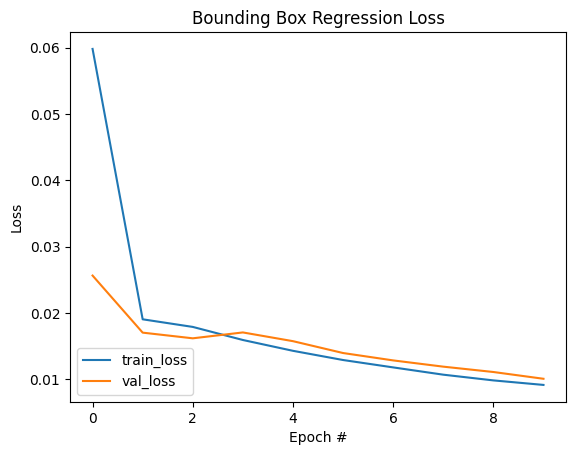

In [8]:
# plot the model training history
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, NUM_EPOCHS), history.history['val_loss'], label='val_loss')
plt.title('Bounding Box Regression Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()

## Evaluate the model
Predict class and bounding box on test images.

1/1 [==============================] - 0s 34ms/step
mean_iou: 0.605596065124117


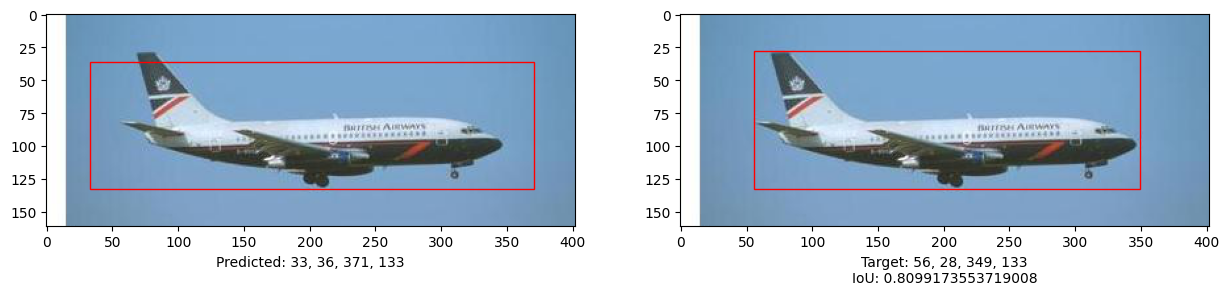

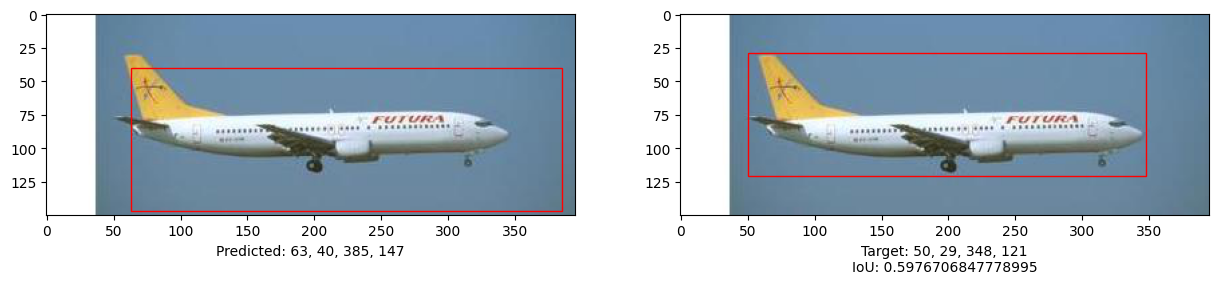

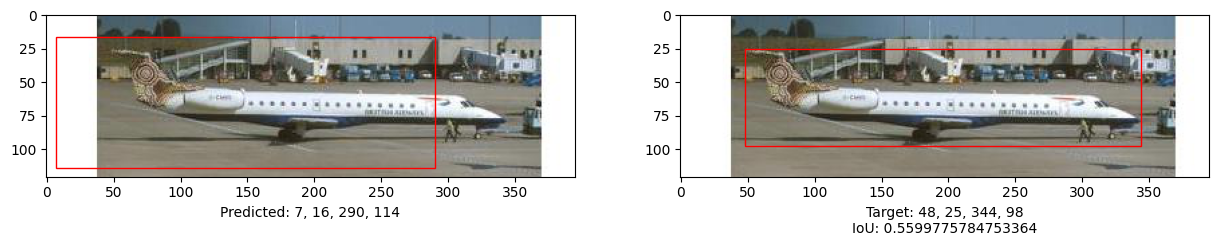

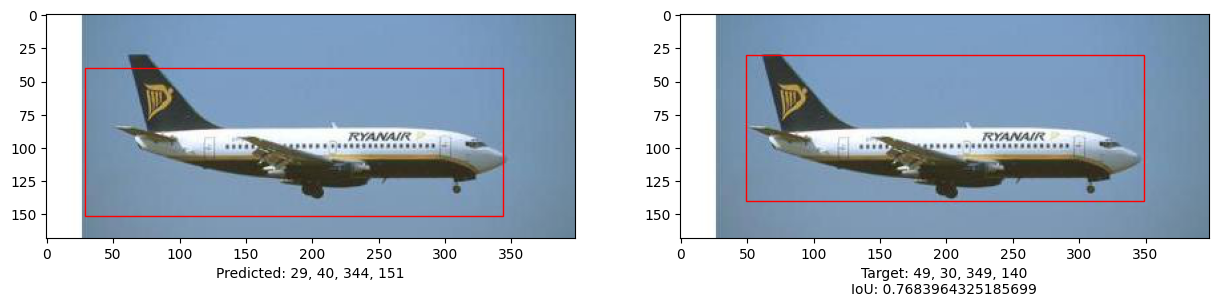

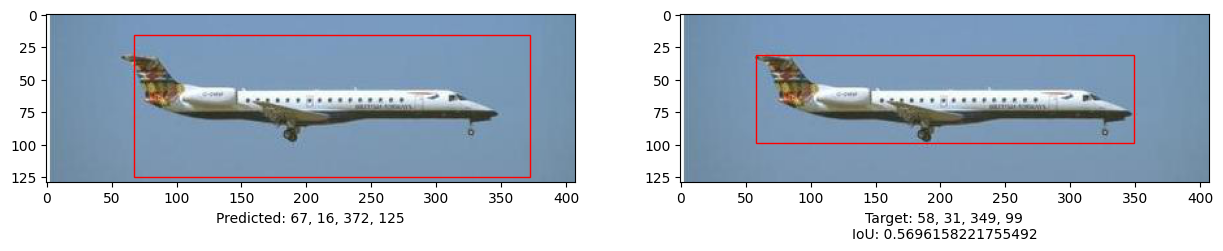

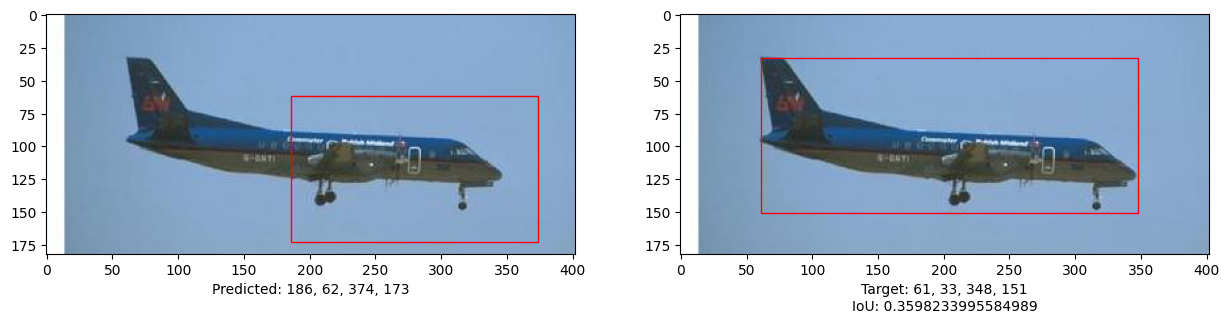

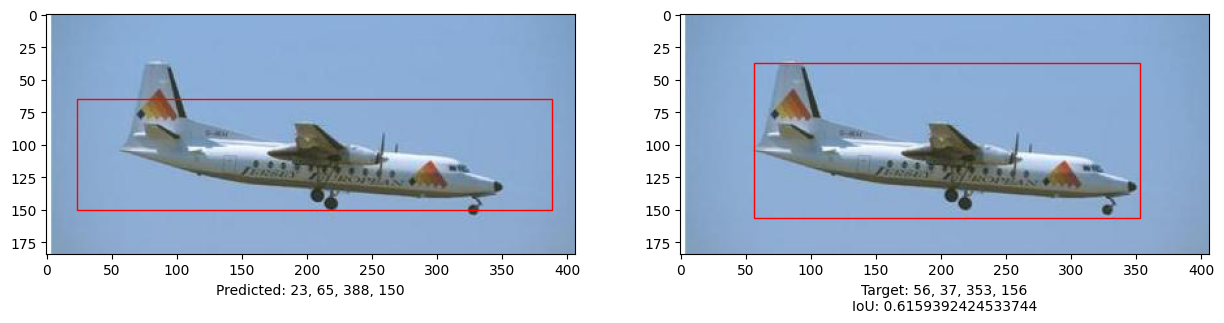

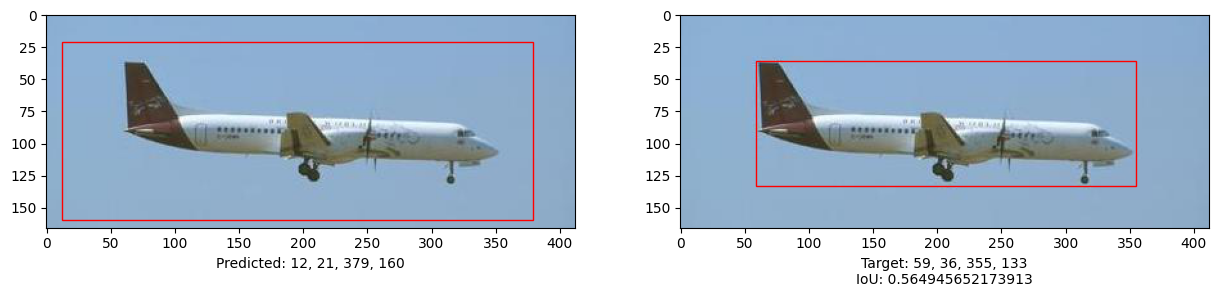

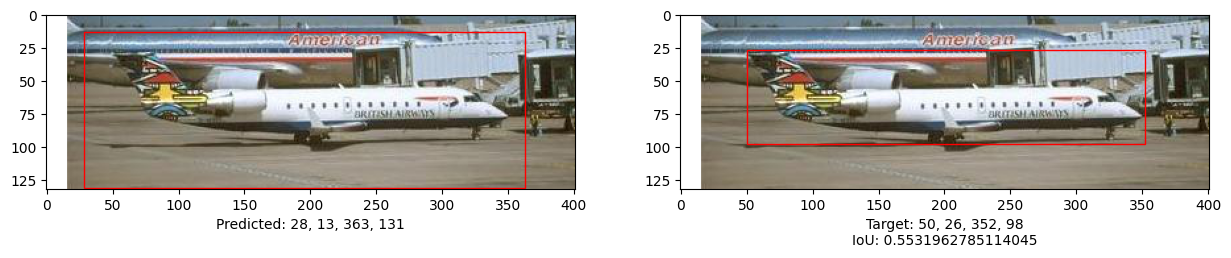

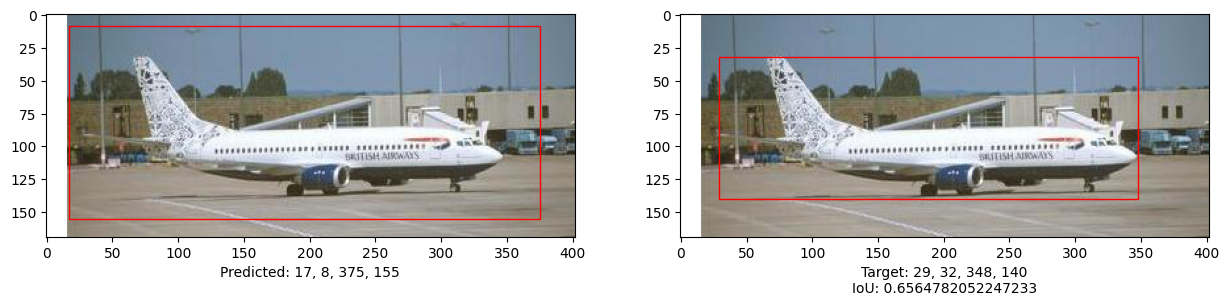

In [9]:
import matplotlib.patches as patches

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU: "
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()